In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#sb.set_style("whitegrid")
plt.style.use('seaborn-poster')
plt.rcParams["figure.figsize"] = (15,7)

from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pickle, joblib
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

# https://open.spotify.com/?_ga=2.265625417.797707606.1505306803-1834882372.1504873173

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
def evals_():
    print("y_train / y_train_pred ")
    eval_metrics(y_train, y_train_pred)
    #print("y_test / y_test_pred ")
    #eval_metrics(y_test, y_test_pred)
    
def rms_() :   #  RMS
    trainscore = int(math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train Score: %.f RMSE" % (trainscore))
    #testscore = int(math.sqrt(mean_squared_error(y_test, y_test_pred)))
    #print("Test Score: %.f RMSE" % (testscore))


# Visualising the results
def ploty(real,predicted)  :
    plt.plot(real,      color = 'red' , label = '  Real Price'     )   # Real Stock price
    plt.plot(predicted, color = 'blue', label = '  Predicted Price')
    plt.xlabel('Day') ; plt.ylabel(' Price') ; plt.legend()
    plt.show()
    
def plot_():
    #ploty(y_train,y_train_pred)    # TRAIN
    ploty(y_test,y_test_pred)       # TEST
    


In [5]:
# Load data
df = pd.read_csv('C:\\dev\\data\\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.index = df.Timestamp
df_day= df.resample('D').mean()
df_day.head(10)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
2012-01-05,6.281429,6.286190,6.281429,6.286190,4.514373,27.987370,6.284127
2012-01-06,6.435000,6.445000,6.435000,6.445000,2.420196,15.914659,6.438999
2012-01-07,6.800000,6.800000,6.800000,6.800000,0.295858,2.011834,6.800000
2012-01-08,6.950000,6.950000,6.950000,6.950000,2.500000,17.300000,6.950000


In [42]:
df_day = df_day['2016-01-01':]

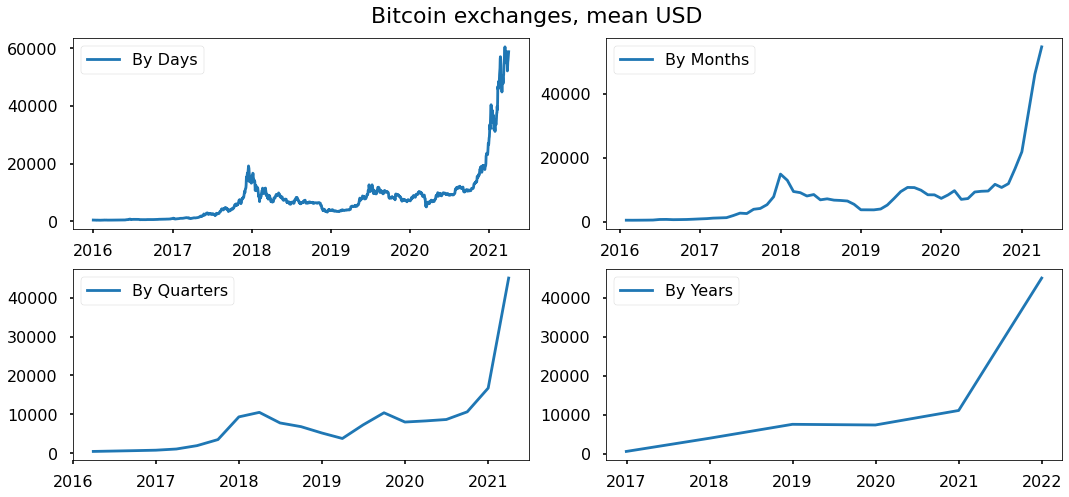

In [43]:
# Resampling to monthly frequency
df_month = df_day.resample('M').mean()

# Resampling to quarterly frequency
df_Q = df_day.resample('Q-DEC').mean()

# Resampling to annual frequency
df_year = df_day.resample('A-DEC').mean()

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)
plt.subplot(221)
plt.plot(df_day.Weighted_Price, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1080x504 with 0 Axes>

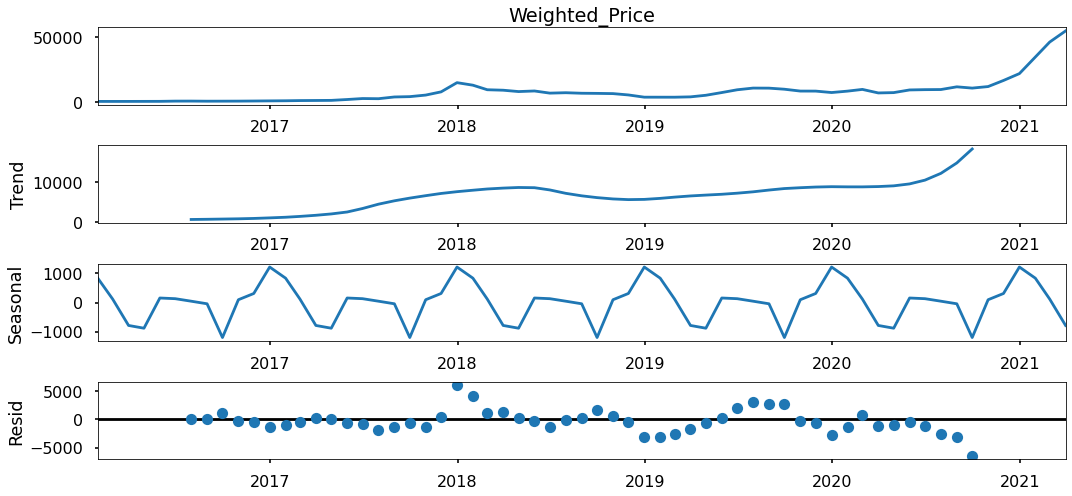

In [44]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
plt.show()


In [45]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])


Dickey–Fuller test: p=0.997064


In [46]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
df_month.tail(2)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box
Timestamp,,,,,,,,
2021-02-28,46076.500756,46116.985465,46035.188338,46077.063198,5.964004,274306.654409,46074.940877,31.001800
2021-03-31,54639.891296,54674.763269,54605.192891,54641.412965,3.527373,192206.908427,54638.339142,32.096037


In [47]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price_box)[1])


Dickey–Fuller test: p=0.929151


In [48]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])


Dickey–Fuller test: p=0.578013


In [49]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
df_month.head(15)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
Timestamp,,,,,,,,,,
2016-01-31,411.138505,411.290954,410.944888,411.130180,8.138383,3305.568525,411.109742,10.548827,NaN,NaN
2016-02-29,402.000503,402.123633,401.850096,402.007439,6.858360,2764.547228,401.981703,10.485806,NaN,NaN
2016-03-31,415.214463,415.326648,415.086267,415.219670,4.693774,1944.107697,415.199716,10.576688,NaN,NaN
2016-04-30,433.167993,433.278907,433.057194,433.174330,3.815150,1671.509798,433.165553,10.696448,NaN,NaN
2016-05-31,460.008041,460.152174,459.843508,460.012398,4.759895,2228.209241,459.996156,10.867857,NaN,NaN
2016-06-30,638.406656,638.780045,637.973464,638.398353,8.542542,5519.207120,638.371131,11.834291,NaN,NaN
2016-07-31,660.441969,660.698388,660.181687,660.444526,4.502063,2968.060528,660.427920,11.937614,NaN,NaN
2016-08-31,578.385873,578.599363,578.166150,578.389208,4.916563,2813.109413,578.378425,11.537491,NaN,NaN
2016-09-30,602.913054,603.086477,602.729790,602.906350,3.464194,2086.403282,602.907898,11.661791,NaN,NaN


In [50]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

Dickey–Fuller test: p=0.001188


<Figure size 1080x504 with 0 Axes>

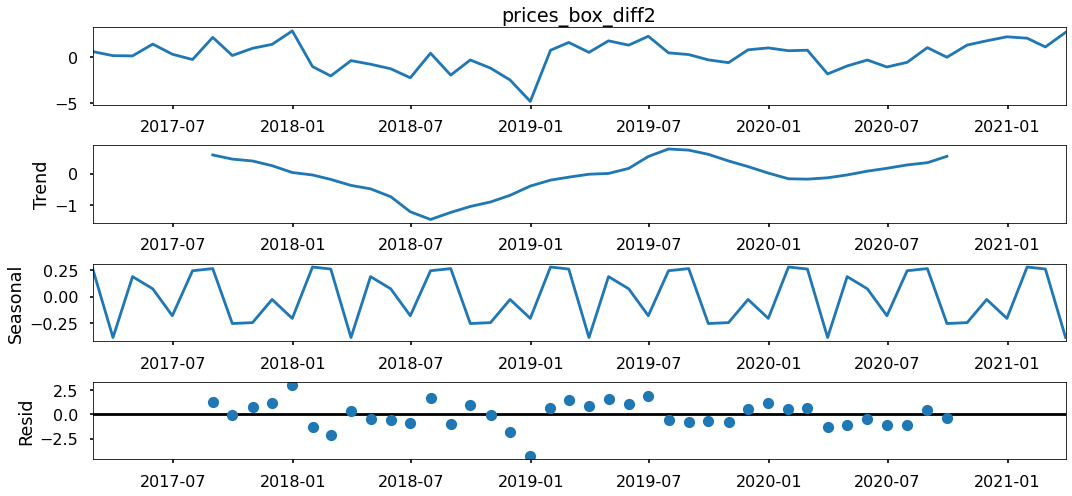

In [51]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
plt.show()

In [52]:
df_month['Weighted_Price_diff'] = np.log(df_month['Weighted_Price']) - np.log(df_month['Weighted_Price'].shift(1))
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price_diff[1:])[1])

Dickey–Fuller test: p=0.000006


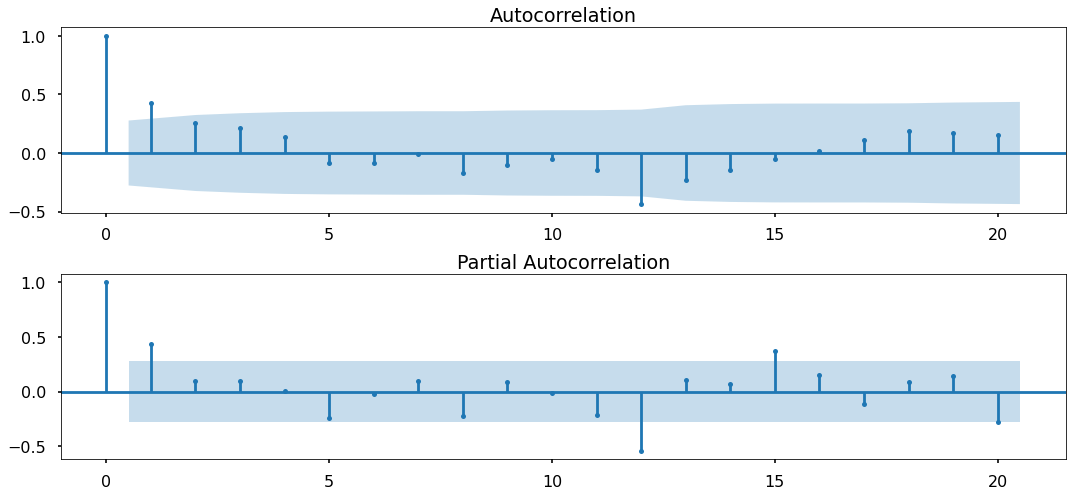

In [56]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=20, ax=ax)
plt.tight_layout()
plt.show()

In [57]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [58]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())


      parameters         aic
19  (1, 0, 0, 1)  156.289787
22  (1, 0, 2, 0)  157.526820
25  (1, 1, 0, 1)  157.612565
37  (2, 0, 0, 1)  157.919115
7   (0, 1, 0, 1)  158.017858
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   63
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -75.145
Date:                              Tue, 28 Dec 2021   AIC                            156.290
Time:                                      17:51:43   BIC                            162.026
Sample:                                  01-31-2016   HQIC                           158.474
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


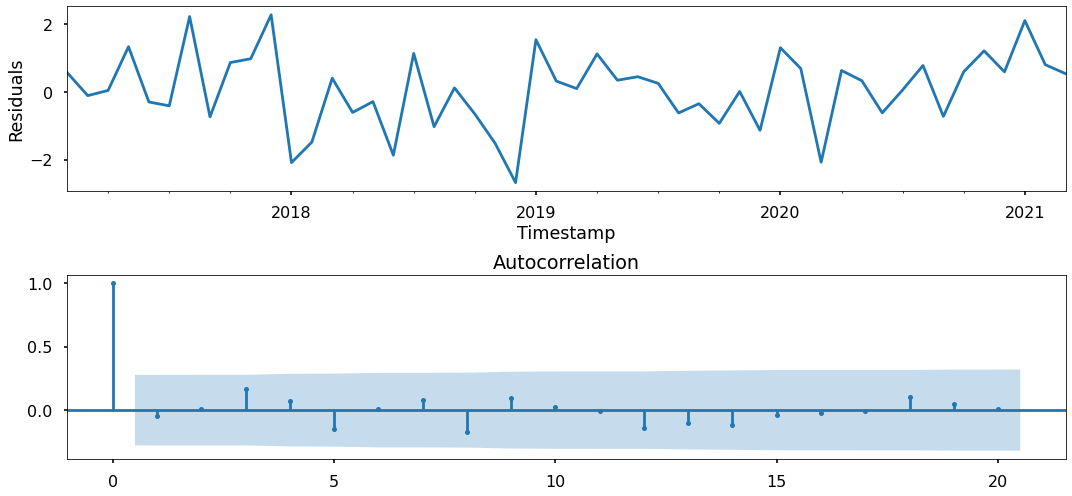

In [59]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=20, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [60]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


In [61]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

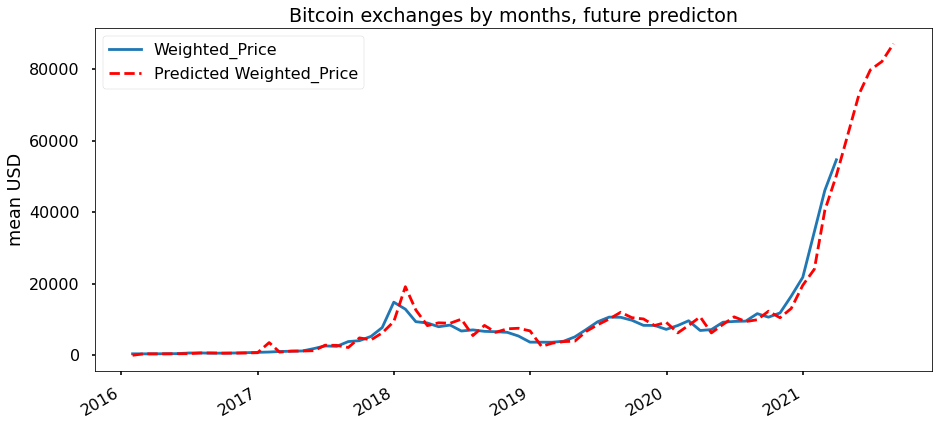

In [62]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 3, 31), datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30), 
             datetime(2021,7, 31), datetime(2021, 8, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=76), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges by months, future predicton')
plt.ylabel('mean USD')
plt.show()


<Figure size 1080x504 with 0 Axes>

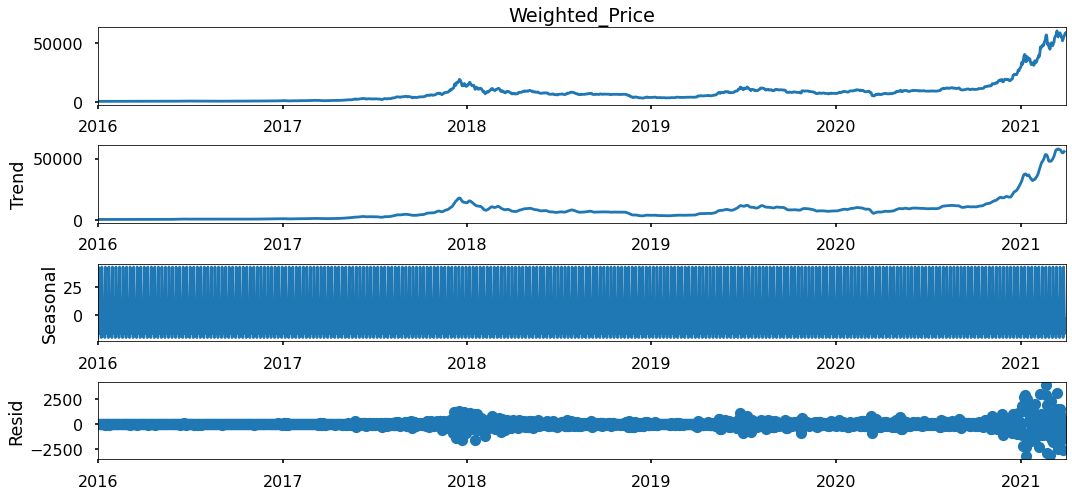

Dickey–Fuller test: p=1.000000


In [63]:
## Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_day.Weighted_Price).plot()
plt.show()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Weighted_Price)[1])


In [64]:
df_day['Weighted_Price_box'], lmbda = stats.boxcox(df_day.Weighted_Price)
df_day.head(2)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Weighted_Price_box)[1])

# Seasonal differentiation
df_day['prices_box_diff'] = df_day.Weighted_Price_box - df_day.Weighted_Price_box.shift(7)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.prices_box_diff[7:])[1])

Dickey–Fuller test: p=0.985865
Dickey–Fuller test: p=0.000000


In [65]:
df_day['prices_box_diff2'] = df_day.prices_box_diff - df_day.prices_box_diff.shift(1)
df_day.head(10)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
Timestamp,,,,,,,,,,
2016-01-01,432.749737,432.946640,432.577646,432.777097,4.329270,1874.946201,432.762815,10.598848,NaN,NaN
2016-01-02,433.115206,433.226892,432.986124,433.088991,3.408330,1476.804343,433.102496,10.601040,NaN,NaN
2016-01-03,429.070606,429.266037,428.876561,429.064671,4.693118,2011.450304,429.069676,10.574919,NaN,NaN
2016-01-04,432.435061,432.562112,432.303786,432.447102,5.834281,2525.278059,432.434197,10.596726,NaN,NaN
2016-01-05,432.376140,432.438880,432.284880,432.375800,3.881721,1677.111442,432.353912,10.596207,NaN,NaN
2016-01-06,430.419106,430.488801,430.312308,430.408980,4.926310,2118.995041,430.404131,10.583585,NaN,NaN
2016-01-07,448.847934,449.014756,448.651305,448.856685,13.477517,6033.957802,448.830293,10.701020,NaN,NaN
2016-01-08,454.456112,454.568951,454.285533,454.445099,9.275764,4208.840860,454.421113,10.735860,0.137012,NaN
2016-01-09,450.200917,450.293380,450.070586,450.172527,4.686615,2107.601054,450.167102,10.709383,0.108343,-0.028669


<Figure size 1080x504 with 0 Axes>

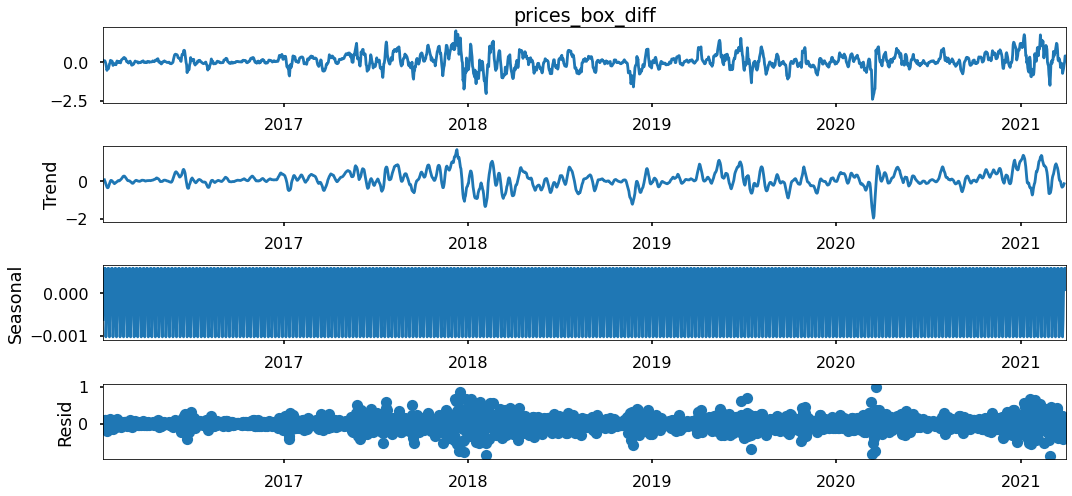

In [66]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_day.prices_box_diff[7:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

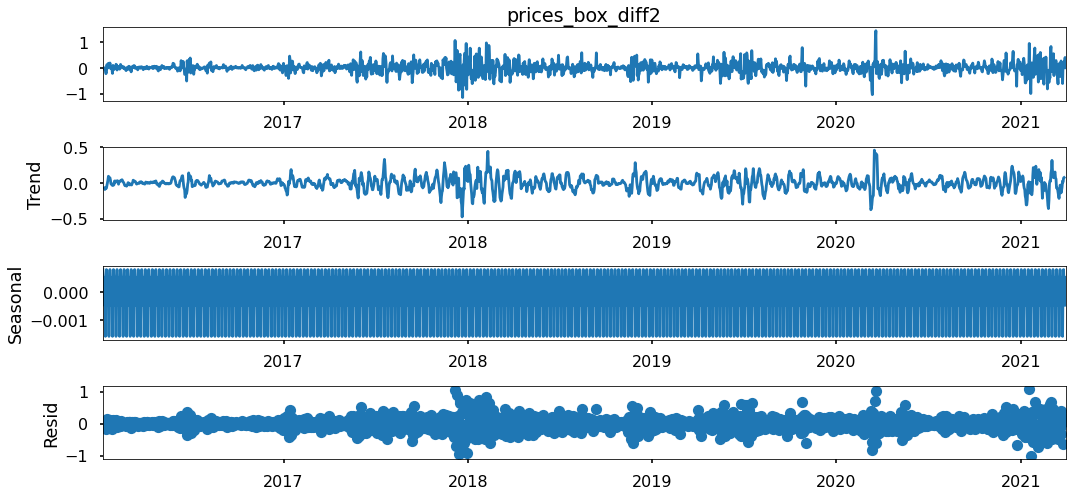

In [67]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_day.prices_box_diff2[8:]).plot()   
plt.show()

<Figure size 1080x504 with 0 Axes>

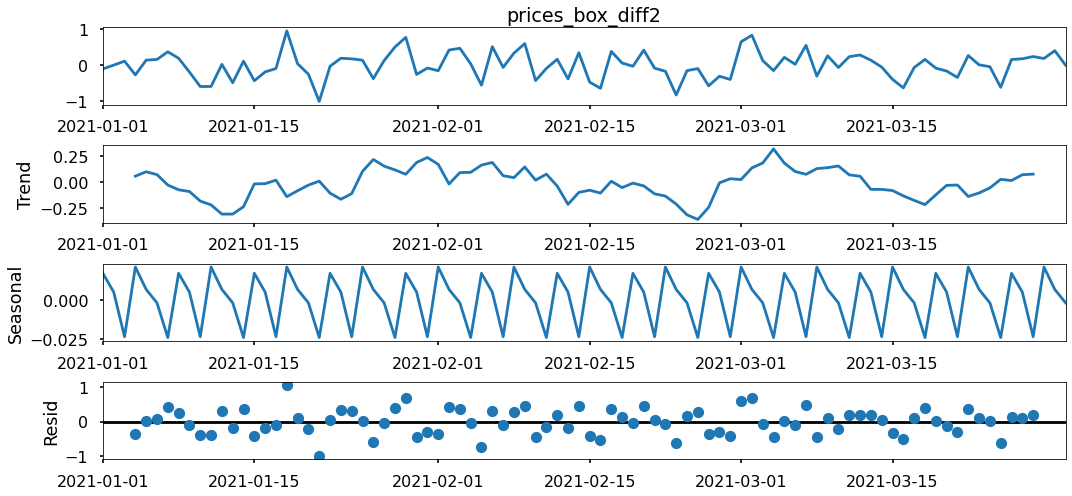

In [68]:
# STL-decomposition  # Last 90 days 
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_day.prices_box_diff2[-90:]).plot()   
plt.show()

In [69]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.prices_box_diff2[8:])[1])


Dickey–Fuller test: p=0.000000


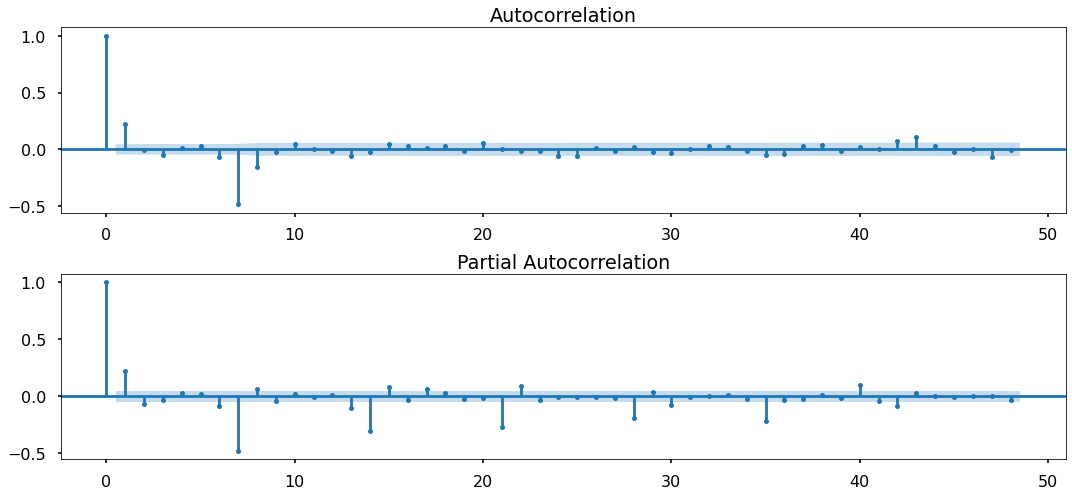

In [70]:
#### The series are stationary.
## ACF Autocorrelation Function Plot
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_day.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_day.prices_box_diff2[8:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [71]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_day.Weighted_Price_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [72]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
7   (0, 1, 0, 1) -1944.283501
37  (2, 0, 0, 1) -1942.533868
13  (0, 2, 0, 1) -1942.452390
25  (1, 1, 0, 1) -1942.436425
9   (0, 1, 1, 1) -1942.415617
                                     SARIMAX Results                                     
Dep. Variable:                Weighted_Price_box   No. Observations:                 1917
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                 975.142
Date:                           Tue, 28 Dec 2021   AIC                          -1944.284
Time:                                   18:07:26   BIC                          -1927.620
Sample:                               01-01-2016   HQIC                         -1938.151
                                    - 03-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

Dickey–Fuller test:: p=0.000000


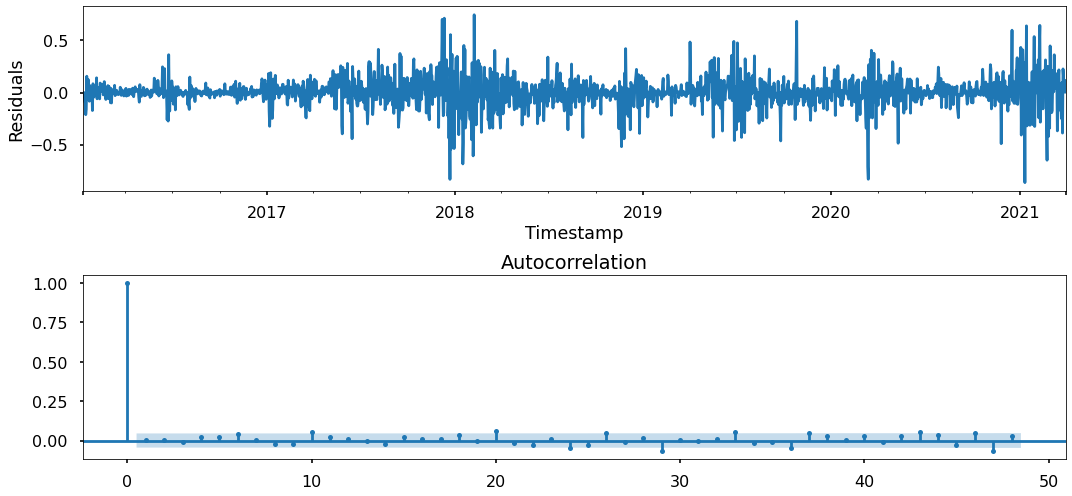

In [74]:
## Analysis of residues
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[8:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[8:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [73]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


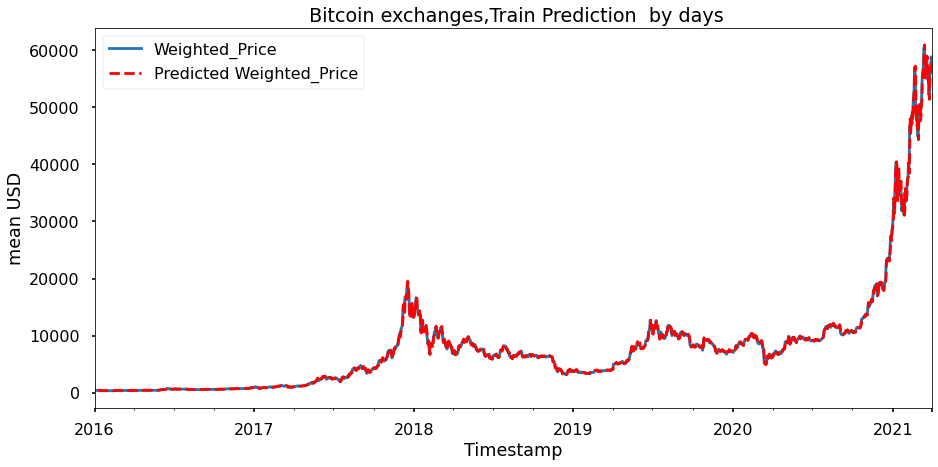

,Weighted_Price,forecast
Timestamp,,
2016-01-01,432.762815,NaN
2016-01-02,433.102496,NaN
2016-01-03,429.069676,NaN
2016-01-04,432.434197,NaN
2016-01-05,432.353912,NaN
...,...,...
2021-03-27,55193.357260,53951.511776
2021-03-28,55832.958824,55482.316571
2021-03-29,56913.993819,56019.699562


In [76]:
end_=len(df_day)

df2 = df_day[['Weighted_Price']]
df2['forecast'] = invboxcox(best_model.predict(start=8, end=end_), lmbda)
plt.figure(figsize=(15,7))
df2.Weighted_Price.plot()
df2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(' Bitcoin exchanges,Train Prediction  by days')
plt.ylabel('mean USD')
plt.show()
df2

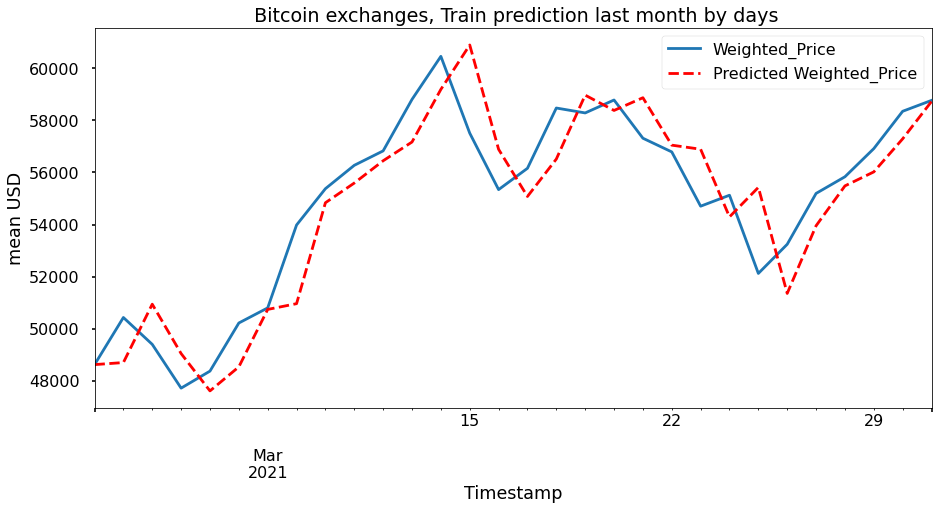

In [77]:
# TRAIN Prediction   Last 30 days of Train prediction
df3= df_day[['Weighted_Price']][-30:]
df3['forecast'] = invboxcox(best_model.predict(start=end_-30, end=end_), lmbda)
plt.figure(figsize=(15,7))
df3.Weighted_Price.plot()
df3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(' Bitcoin exchanges, Train prediction last month by days')
plt.ylabel('mean USD')
plt.show()

In [78]:
y_train=df3.Weighted_Price
y_train_pred=df3.forecast
evals_()

y_train / y_train_pred 
------------------------------------
R2_score 	: 0.8123763679316758
MAE 		: 1243.2275222973478
MSE 		: 2345441.8192790556
RMSE 		: 1531.4835354253912


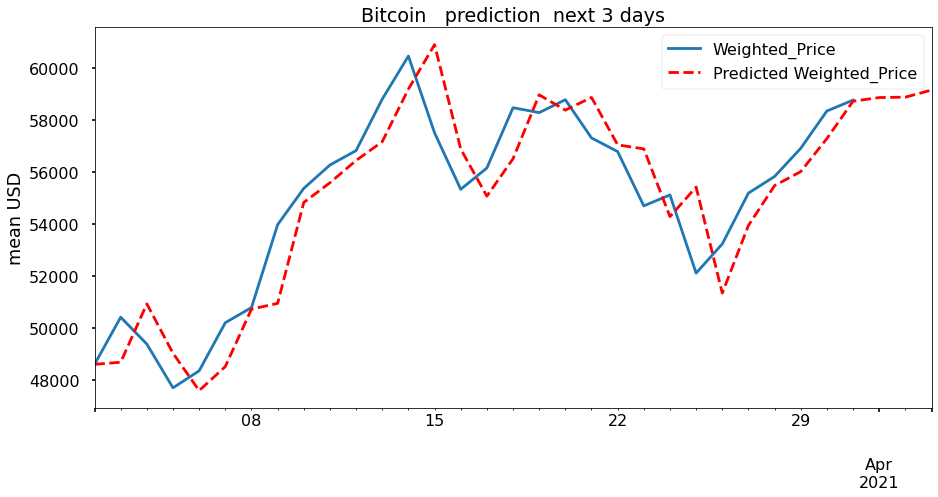

In [79]:
# Prediction  for next 3 days
df4 = df_day[['Weighted_Price']][-30:]
date_list =[datetime(2021, 4,1), datetime(2021,4,2), datetime(2021,4,3)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df4 = pd.concat([df3, future])
df4['forecast'] = invboxcox(best_model.predict(start=end_-30, end=end_+3), lmbda)
plt.figure(figsize=(15,7))
df4.Weighted_Price.plot()
df4.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin   prediction  next 3 days')
plt.ylabel('mean USD')
plt.show()

In [81]:
df4[["Weighted_Price","forecast"]].tail(5)   # The last 3 days are forecasted days
dff=df4[["forecast"]].iloc[-30:,]
dff.tail()

,forecast
2021-03-30,57289.221387
2021-03-31,58723.159629
2021-04-01,58862.290169
2021-04-02,58877.792746
2021-04-03,59150.038178


In [82]:
df_day["Weighted_Price"]

Timestamp
2016-01-01      432.762815
2016-01-02      433.102496
2016-01-03      429.069676
2016-01-04      432.434197
2016-01-05      432.353912
                  ...     
2021-03-27    55193.357260
2021-03-28    55832.958824
2021-03-29    56913.993819
2021-03-30    58346.912268
2021-03-31    58764.349363
Freq: D, Name: Weighted_Price, Length: 1917, dtype: float64